In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_r import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')

In [4]:
trn_session, trn_tracking, val_session, val_tracking = \
generate_validation_set(all_session, all_tracking, test_size=0.1, seed=42)

In [5]:
trn_session.shape

(119810, 2)

In [6]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

# Validation

In [7]:
import lightgbm as lgbm

X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train)

X_train_pca = pd.DataFrame(pca.transform(X_train))
X_val_pca = pd.DataFrame(pca.transform(X_val))

X_train = pd.concat([X_train, X_train_pca], axis=1)
X_val = pd.concat([X_val, X_val_pca], axis=1)

In [9]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100)

[1]	valid_0's binary_logloss: 0.308859
[2]	valid_0's binary_logloss: 0.302183
[3]	valid_0's binary_logloss: 0.29728
[4]	valid_0's binary_logloss: 0.29347
[5]	valid_0's binary_logloss: 0.290558
[6]	valid_0's binary_logloss: 0.288123
[7]	valid_0's binary_logloss: 0.286237
[8]	valid_0's binary_logloss: 0.285469
[9]	valid_0's binary_logloss: 0.284094
[10]	valid_0's binary_logloss: 0.282928
[11]	valid_0's binary_logloss: 0.28211
[12]	valid_0's binary_logloss: 0.281856
[13]	valid_0's binary_logloss: 0.281183
[14]	valid_0's binary_logloss: 0.280541
[15]	valid_0's binary_logloss: 0.279941
[16]	valid_0's binary_logloss: 0.279568
[17]	valid_0's binary_logloss: 0.27917
[18]	valid_0's binary_logloss: 0.278809
[19]	valid_0's binary_logloss: 0.278536
[20]	valid_0's binary_logloss: 0.278366
[21]	valid_0's binary_logloss: 0.278304
[22]	valid_0's binary_logloss: 0.278174
[23]	valid_0's binary_logloss: 0.278009
[24]	valid_0's binary_logloss: 0.277905
[25]	valid_0's binary_logloss: 0.27778
[26]	valid_0's

# Model

In [10]:
X_all = proc_all.drop('sid', axis=1)
y_all = all_session.target

X_test = proc_test.drop('sid', axis=1)

temp_columns = X_all.columns
X_test = X_test[temp_columns]

from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_all)
X_all = pd.concat([X_all, pd.DataFrame(pca.transform(X_all))], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(pca.transform(X_test))], axis=1)

import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=100)

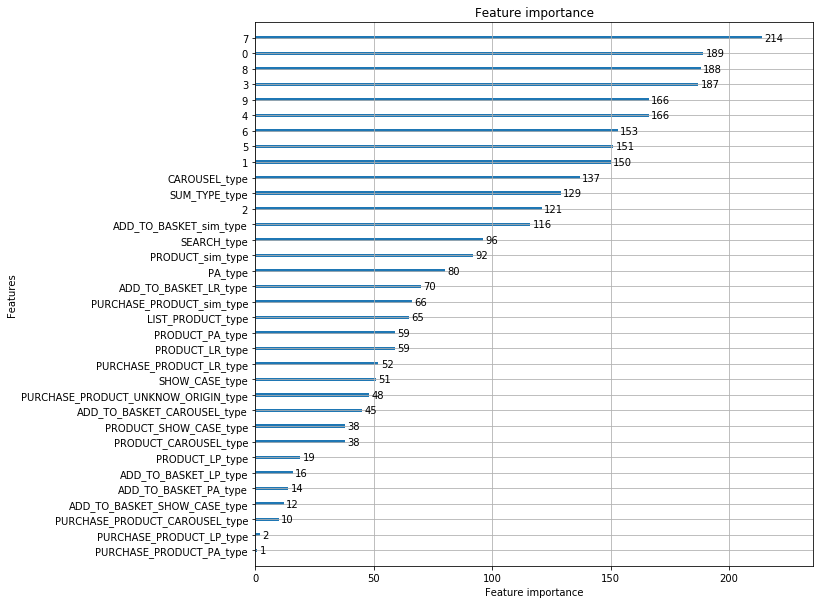

In [11]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [12]:
count = 1
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_{count}_submit.csv', index=False)

In [13]:
from sklearn.metrics import log_loss

In [14]:
count = 2

In [15]:
X_all.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.00,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,4.0,0.0,0.250000,0.0,0.00,0.250000,0.0,0.500000,0.0,4.0,-8.738210,-0.236668,-0.215408,-0.119465,0.063152,0.160373,-0.071926,-0.053851,0.000248,0.003187
1,0.0,0.0,0.0,0.0,0.0,0.307692,0.0,0.00,0.076923,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384615,0.0,13.0,0.0,0.307692,0.0,0.00,0.307692,0.0,0.384615,0.0,13.0,3.989560,-0.040544,-0.204264,-0.093161,0.048300,0.210844,-0.007196,-0.046768,-0.020358,0.005340
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,4.0,0.0,0.000000,0.0,0.25,0.250000,0.0,0.500000,0.0,4.0,-8.738763,-0.437704,0.077511,0.128111,-0.181200,0.195404,-0.040749,-0.047041,-0.016519,0.001377
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,4.0,0.0,0.000000,0.0,0.00,0.000000,0.0,1.000000,0.0,4.0,-8.737744,-0.998629,-0.238878,-0.130982,0.104128,-0.215489,0.079601,-0.003660,0.016551,0.000551
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,3.0,0.0,0.000000,0.0,0.00,0.000000,0.0,1.000000,0.0,3.0,-10.151954,-0.999747,-0.239586,-0.133590,0.104895,-0.214677,0.079654,-0.003147,0.016559,0.000491


In [16]:
y_all.head()

0    False
1    False
2    False
3    False
4    False
Name: target, dtype: bool

In [17]:
from sklearn.linear_model import RidgeCV

In [18]:
regr_cv = RidgeCV([5.5, 5.6, 5.7, 5.8, 6.0])

In [19]:
model_cv = regr_cv.fit(X_train, y_train)

In [21]:
cv_prediction = model_cv.predict(X_val)

In [22]:
cv_prediction

array([0.12049183, 0.04950167, 0.06840467, ..., 0.0612658 , 0.07541898,
       0.02733121])

In [23]:
log_loss(y_val, cv_prediction)

0.28788346599425013

In [23]:
len(X_all)

133123

In [24]:
from scipy.stats import skew
from scipy.special import boxcox1p

In [25]:
numeric_feats = X_all.dtypes[X_all.dtypes != "object"].index

In [26]:
skewed_feats = X_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

skewed_feats = skewed_feats[skewed_feats > 0.65]

skewed_feats = skewed_feats.index

In [27]:
X_train[skewed_feats] = boxcox1p(X_train[skewed_feats], 0.15)

In [28]:
X_val[skewed_feats] = boxcox1p(X_val[skewed_feats], 0.15)

In [29]:
regr_cv = RidgeCV([5.5, 5.6, 5.7, 5.8, 6.0])

In [32]:
X_train = X_train.fillna(X_all.mean())
X_val = X_val.fillna(X_all.mean())

In [33]:
regr_cv.fit(X_train, y_train)

RidgeCV(alphas=[5.5, 5.6, 5.7, 5.8, 6.0], cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [34]:
cv_prediction = model_cv.predict(X_val)
log_loss(y_val, cv_prediction)

0.2863403361127427